# Approximating the Lyapunov Exponent of the Lorenz System in NumPy

The Lorenz equations are a prototypical example of **deterministic chaos**. They
are a system of three **nonlinear** ODEs

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma(y - x), \\
\frac{dy}{dt} &= x(\rho - z) - y, \\
\frac{dz}{dt} &= xy - \beta z.
\end{aligned}
$$

The three variables can be combined into the state vector $u = (x, y, z) \in
\mathbb{R}^3$. Assume we have an initial condition $u(0)$ and another one
slightly next to it $\tilde{u}(0)$. Hence, their difference is $\delta u(0) =
\tilde{u}(0) - u(0)$. The maximum Lyapunov exponent $\lambda$ describes how
(exponentially) quickly the two trajectories diverge

$$
\| \delta u(t) \| \approx \| \delta u(0) \| \exp(\lambda t).
$$


In this notebook, we will approximate $\lambda$ for the Lorenz system under the
original configuration $\sigma = 10$, $\rho = 28$ and $\beta = 8/3$ (1) using a
[Runge-Kutta 4
simulator](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/simulation_scripts/lorenz_simulator_numpy.ipynb)
of time step size $\Delta t = 0.01$ with the following strategy:

1. Draw a reasonable initial condition, e.g. $u^{[0]} = (1, 1, 1)$.
2. Evolve the initial condition until it enters the chaotic attractor, e.g., by
   using $5000$ time steps to get $u^{[5000]}$.
3. Use the last state $u^{[5000]}$ as the "warmed-up" initial state $u^{[0]}
   \leftarrow u^{[5000]}$.
4. Perturb this "warmed-up state" by a small amount, e.g. $\delta u^{[0]} =
   10^{-8} \odot \epsilon$ with $\epsilon_i \propto \mathcal{U}(-1, 1)$ to get
   $\tilde{u}^{[0]} = u^{[0]} + \delta u^{[0]}$.
5. Evolve both states simultaneously for a certain number of time steps, e.g.
   another 5000 time steps.
6. Compute the norm of the difference trajectory $\|\delta u^{[t]}\|_2 =
   \|\tilde{u}^{[t]}- u^{[t]}\|_2$ at each time step $t$.
7. Find the range of time steps in which the difference is growing
   (approximately) exponentially linear (e.g., by visual inspection in a
   log-linear plot). It will turn out that using $\approx 2000$ time steps is
   sufficient.
8. Fit a linear affine model to the following dataset $\{ \{t \Delta
   t\}_{t=0}^T, \{ \log(\|\delta u^{[t]}\|_2) \}_{t=0}^{2000}\}$ to approximate
   the Lyapunov exponent $\lambda$.
9. (Optional) repeat the process for different initial conditions or different
   perturbations and average the found Lyapunov exponents.

This notebook is greatly inspired by this [wonderful example of the Chebfun
library](http://www.chebfun.org/examples/ode-nonlin/LyapunovExponents.html).

---

(1) E. N. Lorenz, "Deterministic Nonperiodic Flow", Journal of the Atmospheric
Sciences, 1963,
https://journals.ametsoc.org/view/journals/atsc/20/2/1520-0469_1963_020_0130_dnf_2_0_co_2.xml

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def lorenz_rhs(u, *, sigma, rho, beta):
    x, y, z = u
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    u_dot = np.array([x_dot, y_dot, z_dot])
    return u_dot

In [3]:
class LorenzStepperRK4:
    def __init__(self, dt=0.01, *, sigma=10, rho=28, beta=8/3):
        self.dt = dt
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
    
    def __call__(self, u_prev):
        lorenz_rhs_fixed = lambda u: lorenz_rhs(
            u,
            sigma=self.sigma,
            rho=self.rho,
            beta=self.beta,
        )
        k_1 = lorenz_rhs_fixed(u_prev)
        k_2 = lorenz_rhs_fixed(u_prev + 0.5 * self.dt * k_1)
        k_3 = lorenz_rhs_fixed(u_prev + 0.5 * self.dt * k_2)
        k_4 = lorenz_rhs_fixed(u_prev + self.dt * k_3)
        u_next = u_prev + self.dt * (k_1 + 2*k_2 + 2*k_3 + k_4)/6
        return u_next

In [4]:
lorenz_stepper = LorenzStepperRK4()

In [5]:
u_0 = np.ones(3)

In [6]:
u_0

array([1., 1., 1.])

In [7]:
lorenz_stepper(u_0)

array([1.01256719, 1.2599178 , 0.98489097])

In [8]:
def produce_trj(init, n_steps=5000):
    trj = [init,]
    u_current = init 
    for i in range(n_steps):
        u_current = lorenz_stepper(u_current)
        trj.append(u_current)
    trj = np.array(trj)
    return trj

In [9]:
trj = produce_trj(u_0)

In [10]:
trj.shape

(5001, 3)

In [11]:
u_0_warmed = trj[-1]

In [12]:
u_0_warmed_noise = u_0_warmed + 1e-8 * (np.random.rand(3) * 2 - 1)

In [13]:
np.linalg.norm(u_0_warmed_noise - u_0_warmed)

1.0733389052901085e-08

In [14]:
u_warmed_trj = produce_trj(u_0_warmed)
u_warmed_noise_trj = produce_trj(u_0_warmed_noise)

In [15]:
distance_trj = np.linalg.norm(u_warmed_noise_trj - u_warmed_trj, axis=1)

In [16]:
distance_trj.shape

(5001,)

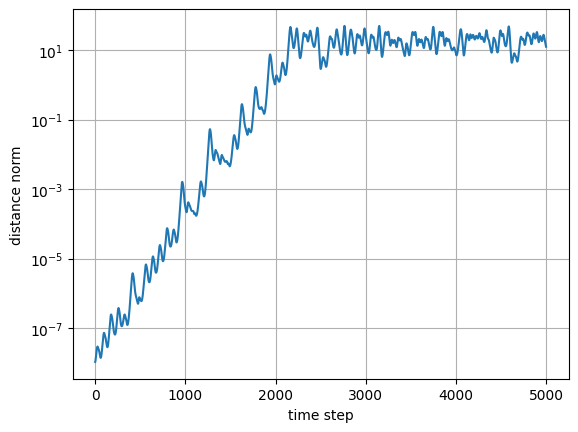

In [17]:
plt.semilogy(distance_trj)
plt.xlabel("time step")
plt.ylabel("distance norm")
plt.grid()

In [18]:
time_points = np.arange(len(distance_trj)) * lorenz_stepper.dt

In [21]:
lyapunov_exponent, log_offset = np.polyfit(time_points[:2000], np.log(distance_trj)[:2000], 1)

lyapunov_exponent

0.9346950260454424

According to

    Viswanath, Divakar. Lyapunov exponents from random Fibonacci sequences to the
    Lorenz equations. Doctoral dissertation. Cornell University, 1998.

page 74, table (c) the Lyaupnov exponent of the Lorenz system is $\lambda
\approx 0.9056$.

Oftentimes the inverse of the Lyapunov exponent, i.e. the Lyapunov time, is used
as a time scale for the system. Many people use to measure the extent of
predictability of a system, i.e., that after a Lyapunov time the system becomes
chaotic.

Since the basis for the exponential analysis is $e$, the distance grows by
$\approx 2.71$ after one Lyapunov time $\bar{t}$. Conversely, this means that
after $\approx 2.3$ Lyapunov times, the distance has grown by one order of
magnitude, after $\approx 4.6 \bar{t}$ this is two orders of magnitude, and
after $\approx 10 \bar{t}$ this is approx four orders magnitude.

- $t= \frac{1}{\lambda}$: distance grows by $e$, i.e., $\frac{\| \delta u^{[t]}
  \|}{\| \delta u^{[0]} \|} \approx 2.71$.
- $t= 2.3 \frac{1}{\lambda}$: distance grows by one order of magnitude, i.e.,
  $\frac{\| \delta u^{[t]} \|}{\| \delta u^{[0]} \|} \approx 10$.
- $t= 4.6 \frac{1}{\lambda}$: distance grows by two orders of magnitude, i.e.,
    $\frac{\| \delta u^{[t]} \|}{\| \delta u^{[0]} \|} \approx 100$.
- $t= 10 \frac{1}{\lambda}$: distance grows by four orders of magnitude, i.e.,
    $\frac{\| \delta u^{[t]} \|}{\| \delta u^{[0]} \|} \approx 10^4$.
- $t= 20 \frac{1}{\lambda}$: distance grows by eight orders of magnitude, i.e.,
    $\frac{\| \delta u^{[t]} \|}{\| \delta u^{[0]} \|} \approx 10^8$.

Text(0, 0.5, 'distance norm')

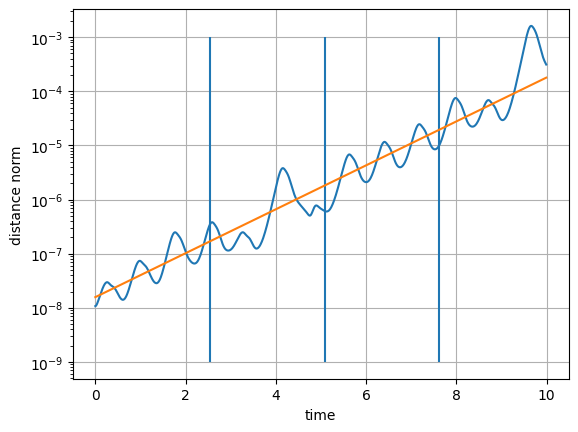

In [23]:
TRUE_LYAPUNOV_EXPONENT = 0.9056

plt.semilogy(time_points[:1000], distance_trj[:1000])
plt.grid()
plt.vlines(1 * 2.3 * 1/TRUE_LYAPUNOV_EXPONENT, 1e-9, 1e-3)
plt.vlines(2 * 2.3 * 1/TRUE_LYAPUNOV_EXPONENT, 1e-9, 1e-3)
plt.vlines(3 * 2.3 * 1/TRUE_LYAPUNOV_EXPONENT, 1e-9, 1e-3)
plt.plot(
    time_points[:1000],
    np.exp(log_offset + lyapunov_exponent * time_points[:1000])
)
plt.xlabel("time")
plt.ylabel("distance norm")